In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import tree
from collections import defaultdict
import random
import pydot
from io import StringIO
import pydotplus

In [233]:
df = pd.read_csv('movie_metadata.csv')

In [234]:
df.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [235]:
print(df.isnull().sum()) # columns with missing data

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64


In [236]:
dataset = df[['gross', 'imdb_score', 'movie_title']
                 ].dropna().values.tolist()

In [237]:
def kMedoids(data, k, prev_cost, count, clusters=None, medoids=None):

    cluster_sum = 0
    random.seed(0)

    while True:

        if medoids is None or not medoids:
            medoids = random.sample(data, k)
        else:
            random.shuffle(medoids)
            for _ in range(0, int(k/2)):
                medoids.pop()
            medoids += random.sample(data, int(k/2))

        clusters = defaultdict(list)

        for item in data:
            temp = []
            for i in range(0, len(medoids)):
                med = medoids[i]
                if med is None or not med:
                    break
                else:
                    temp.append(np.linalg.norm(
                        med[0]-item[0])+np.linalg.norm(med[1]-item[1]))
            min_index = np.argmin(temp)
            clusters[min_index].append(item)

        for i in range(0, len(medoids)):
            inter_cluster = clusters[i]
            for j in range(0, len(inter_cluster)):
                item_cluster = inter_cluster[j]
                medoid = medoids[i]
                cluster_sum += (np.linalg.norm(medoid[0]-item_cluster[0]) +
                                np.linalg.norm(medoid[1]-item_cluster[1]))

        if cluster_sum < prev_cost:
            prev_cost = cluster_sum
        else:
            break

        count += 1

    return clusters

In [238]:
clusters = kMedoids(dataset, 5, np.inf, 0)
for i in range(0,len(clusters)):
    print(str(i+1),len(clusters.get(i)))

1 397
2 1028
3 1081
4 1313
5 340


No handles with labels found to put in legend.


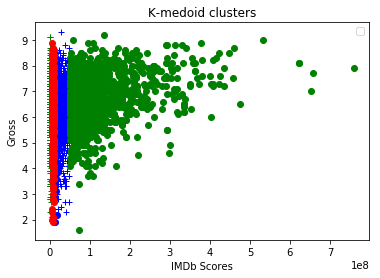

In [239]:
def plot_graph(clusters):
    markers = ['bo', 'g+','b+','go', 'ro','r+' ]
    for i in range(0, len(clusters.keys())):
        data = clusters.get(i)
        for j in range(0, len(data)):
            df = data[j]
            plt.plot(df[0], df[1], markers[i])
    plt.xlabel('IMDb Scores')
    plt.ylabel('Gross')
    plt.title('K-medoid clusters')
    plt.legend()
    plt.show()

plot_graph(clusters)

In [240]:
columns = ['num_user_for_reviews', 'budget',
               'content_rating', 'movie_facebook_likes', 'num_critic_for_reviews', 'movie_title']

df = df[columns].dropna()
print(df.head())

   num_user_for_reviews       budget content_rating  movie_facebook_likes  \
0                3054.0  237000000.0          PG-13                 33000   
1                1238.0  300000000.0          PG-13                     0   
2                 994.0  245000000.0          PG-13                 85000   
3                2701.0  250000000.0          PG-13                164000   
5                 738.0  263700000.0          PG-13                 24000   

   num_critic_for_reviews                                movie_title  
0                   723.0                                    Avatar   
1                   302.0  Pirates of the Caribbean: At World's End   
2                   602.0                                   Spectre   
3                   813.0                     The Dark Knight Rises   
5                   462.0                               John Carter   


In [241]:
def assign_target(row, clusters):

    x = row['movie_title']

    for i in range(0, len(clusters.keys())):
        data = clusters.get(i)
        for j in range(0, len(data)):
            df = data[j]
            if df[2] == x:
                row['cluster'] = 'cluster'+str(i)

    return row

In [242]:
df = df.reset_index()
df = df.apply(assign_target, args=(clusters,), axis=1)
df.drop(labels = ['movie_title'], axis = 1, inplace = True)
print(df.tail())

      budget   cluster  index  movie_facebook_likes  num_critic_for_reviews  \
4325  7000.0  cluster1   5033                 19000                   143.0   
4326  7000.0  cluster1   5034                    74                    35.0   
4327  7000.0  cluster1   5035                     0                    56.0   
4328  9000.0  cluster1   5037                   413                    14.0   
4329  1100.0  cluster1   5042                   456                    43.0   

      num_user_for_reviews  
4325                 371.0  
4326                  35.0  
4327                 130.0  
4328                  14.0  
4329                  84.0  


In [243]:
df_before_split = df.copy()

splitSet = StratifiedShuffleSplit(
        n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in splitSet.split(df, df['cluster']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

Y_train = train_set.cluster
X_train = train_set[train_set.columns.drop('cluster').drop('index')]
Y_test = test_set.cluster
X_test = test_set[test_set.columns.drop('cluster').drop('index')]

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
print('Accuracy', decision_tree.score(X_test, Y_test))

TypeError: unorderable types: str() < float()